# Positron Angle Regressor Validation

Load a trained positron angle regressor model and generate validation plots:
- Load model from checkpoint
- Load validation data
- Generate predictions
- Create regression evaluation plots (predicted vs true, residuals, error analysis)

In [1]:
import json
import torch
import numpy as np
from pathlib import Path
from datetime import datetime
from typing import Optional

from pioneerml.zenml import utils as zenml_utils
from pioneerml.metadata import MetadataManager
from pioneerml.data.loaders import load_positron_angle_groups
from pioneerml.training.datamodules import PositronAngleDataModule
from pioneerml.evaluation.plots import plot_regression_diagnostics

PROJECT_ROOT = zenml_utils.find_project_root()
metadata_manager = MetadataManager(root=PROJECT_ROOT)

print(f"Project root: {PROJECT_ROOT}")


Project root: /home/jack/python_projects/pioneerML


## List Available Checkpoints

Find all saved model checkpoints and their metadata files.


In [2]:
# List and print all available checkpoints
checkpoints = metadata_manager.print_checkpoints("PositronAngleModel")

# Select most recent checkpoint (index 0)
if not checkpoints:
    raise ValueError("No checkpoints found for PositronAngleModel")

print(f"\nUsing checkpoint: {checkpoints[0]['checkpoint_path'].name}")


Found 1 checkpoint(s):
  1. positronanglemodel_20251207_193632_positron_angle_optuna_pipeline-2025_12_07-19_36_11_057643_state_dict.pt
     Timestamp:     20251207_193632
     Run:           positron_angle_optuna_pipeline-2025_12_07-19_36_11_057643
     Architecture:  hidden=160, heads=8, layers=2, dropout=0.24390330548865763

Using checkpoint: positronanglemodel_20251207_193632_positron_angle_optuna_pipeline-2025_12_07-19_36_11_057643_state_dict.pt


## Load Model

Reconstruct the model architecture from metadata and load the saved weights.


In [3]:
# Load model using MetadataManager (uses most recent checkpoint by default, index=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, metadata = metadata_manager.load_model(
    "PositronAngleModel",
    index=0,  # Use most recent checkpoint
    device=device,
)

print(f"\nModel loaded successfully on {device}")
print(f"  Checkpoint: {checkpoints[0]['checkpoint_path'].name}")
print(f"  Timestamp: {metadata.timestamp}")
print(f"  Run: {metadata.run_name or 'unknown'}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")



Model loaded successfully on cuda
  Checkpoint: positronanglemodel_20251207_193632_positron_angle_optuna_pipeline-2025_12_07-19_36_11_057643_state_dict.pt
  Timestamp: 20251207_193632
  Run: positron_angle_optuna_pipeline-2025_12_07-19_36_11_057643
  Parameters: 724,963


## Load Validation Data

Load the same data pattern used during training (or a subset for faster validation).

Note: Positron angle data is loaded from `mainTimeGroups_*.npy` files. Angle targets can be embedded in the data or loaded from a separate file.


In [4]:
# Load validation data
# Use the same file pattern as training: mainTimeGroups_*.npy
file_pattern = str(Path(PROJECT_ROOT) / "data" / "mainTimeGroups_*.npy")

# For validation, use full available data (no limiting by default)
# Note: If angle targets are in a separate file, specify angle_targets_pattern
validation_groups = load_positron_angle_groups(
    file_pattern,
    max_files=1,
    limit_groups=None,
    min_hits=2,
    angle_targets_pattern=None,  # Set to pattern if angles are in separate files
    verbose=True,
)

print(f"Loaded {len(validation_groups)} groups for validation")

# Create datamodule
# val_split=0.0 means we use the full set (train split) for evaluation here
datamodule = PositronAngleDataModule(
    records=validation_groups,
    batch_size=128,
    num_workers=0,  # Set to 0 for validation to avoid multiprocessing issues
    val_split=0.0,
    test_split=0.0,
    seed=42,
)
datamodule.setup(stage="fit")

val_dataset = datamodule.val_dataset or datamodule.train_dataset
if val_dataset is None:
    raise ValueError("No validation dataset available")

print(f"Validation dataset size: {len(val_dataset)}")


Limiting to 1 files (from 11 total files found, max_files=1)
Loaded 29370 groups from 1 files with angle targets


Loaded 29370 groups for validation
Validation dataset size: 29370


## Generate Predictions

Run inference on the validation dataset.


In [5]:
from torch_geometric.loader import DataLoader

# Create dataloader
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)

# Generate predictions
all_predictions = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        preds = model(batch)
        all_predictions.append(preds.cpu())
        all_targets.append(batch.y.cpu())

# Concatenate all predictions and targets
predictions = torch.cat(all_predictions, dim=0)
targets = torch.cat(all_targets, dim=0)

# Handle target reshaping if needed
if targets.dim() == 1 and predictions.dim() == 2 and targets.numel() % predictions.shape[-1] == 0:
    targets = targets.view(-1, predictions.shape[-1])
elif targets.dim() == 1:
    targets = targets.unsqueeze(0)

print(f"Generated predictions:")
print(f"  Predictions shape: {predictions.shape}")
print(f"  Targets shape: {targets.shape}")
print(f"  Predictions range: [{predictions.min():.4f}, {predictions.max():.4f}]")
print(f"  Targets range: [{targets.min():.4f}, {targets.max():.4f}]")

# Debug: Check individual angle components
print(f"\nAngle component analysis:")
print(f"  Theta (component 0): range [{targets[:, 0].min():.4f}, {targets[:, 0].max():.4f}]")
print(f"  Phi (component 1): range [{targets[:, 1].min():.4f}, {targets[:, 1].max():.4f}]")

# Check if phi values look like event IDs (integers in a large range)
phi_values = targets[:, 1].numpy()
if phi_values.max() > 1000 and (phi_values == phi_values.astype(int)).all():
    print(f"\n⚠️  WARNING: Phi values appear to be event IDs or other non-angle data!")
    print(f"  Phi values are all integers and range up to {phi_values.max():.0f}")
    print(f"  This suggests the angle data may not be correctly loaded.")
    print(f"  Expected angle range: typically -180 to 180 degrees or -π to π radians")


Generated predictions:
  Predictions shape: torch.Size([29370, 2])
  Targets shape: torch.Size([29370, 2])
  Predictions range: [-11.0026, 222.1106]
  Targets range: [-10.2898, 9999.0000]

Angle component analysis:
  Theta (component 0): range [0.0000, 9999.0000]
  Phi (component 1): range [-10.2898, 10.2018]


## Generate Validation Plots

Create comprehensive regression evaluation plots to assess model performance.


In [6]:
# Create output directory for plots
plots_dir = Path(PROJECT_ROOT) / "artifacts" / "validation_plots" / "positron_angle"
plots_dir.mkdir(parents=True, exist_ok=True)

timestamp_str = metadata.timestamp if metadata else datetime.now().strftime("%Y%m%d_%H%M%S")
plot_prefix = f"positron_angle_{timestamp_str}"

print(f"Generating validation plots in: {plots_dir}")


Generating validation plots in: /home/jack/python_projects/pioneerML/artifacts/validation_plots/positron_angle


### Regression Diagnostics

Comprehensive regression analysis plots including:
- **Predicted vs True**: Scatter plots showing how well predictions match true values for each angle component (theta, phi)
- **Residual Analysis**: Distribution of errors (predicted - true) to identify systematic biases
- **Error by Magnitude**: How error varies with the magnitude of the true angle
- **Per-Coordinate Analysis**: Separate analysis for each angle component

**How to interpret:**
- **Predicted vs True**: Points should lie along the diagonal line (y=x) for perfect predictions
- **Residuals**: Should be centered around zero with no systematic patterns
- **Error distributions**: Should be symmetric and centered at zero
- **Per-coordinate errors**: Helps identify which angle components are easier/harder to predict

**What to look for:**
- Tight clustering around the diagonal indicates accurate predictions
- Systematic offsets indicate bias that could be corrected
- Heteroscedasticity (error variance changes with magnitude) suggests the model struggles at certain angle ranges



Generating regression diagnostic plots...


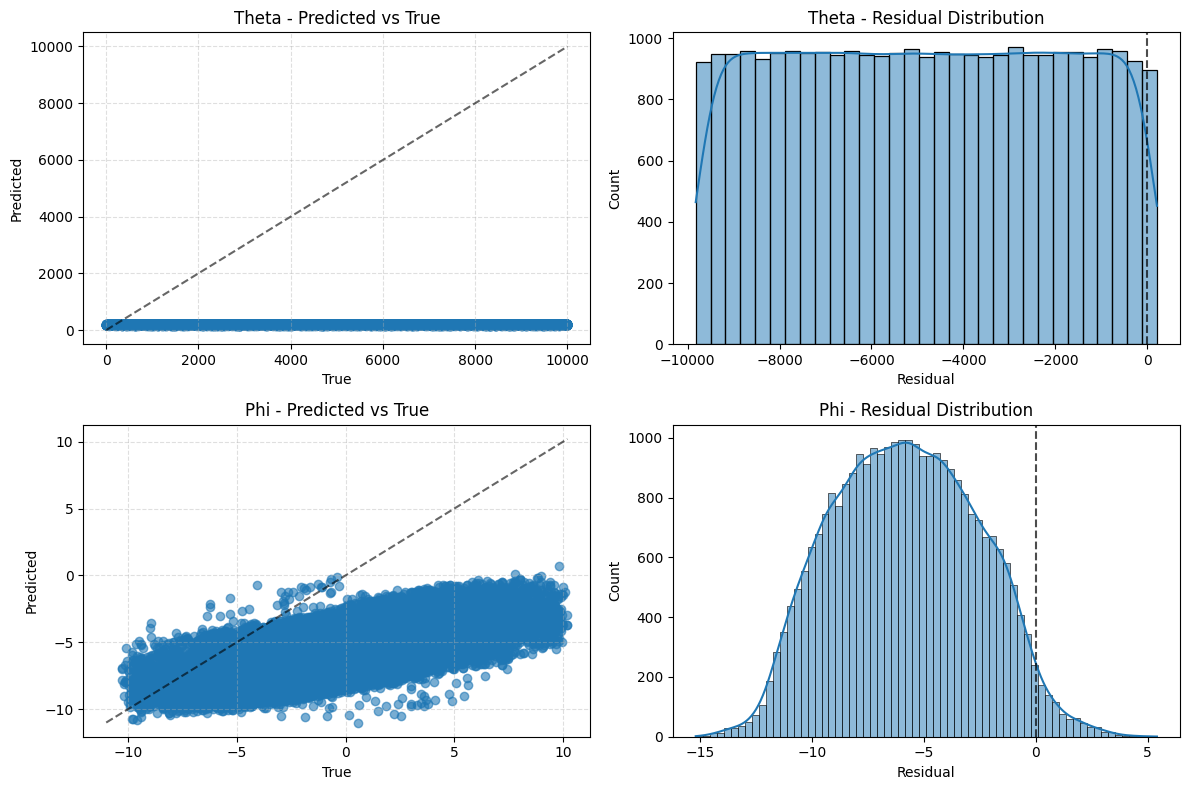

In [7]:
# Generate comprehensive regression diagnostics
# Use component names for better labeling
print("\nGenerating regression diagnostic plots...")
plot_regression_diagnostics(
    predictions=predictions,
    targets=targets,
    component_names=["Theta", "Phi"],  # Label the angle components
    show=True,
)
